![Funcional Health Tech](logo.png "Logo")

**COVID19 - Análise do Surto Brasileiro**

# Análise Exploratória com Inferência de Efeito Causal a partir de SRAGs

Neste *notebook* analisamos os dados reportados de casos de Síntrome Respiratória Aguda Grave (SRAG), sob a hipótese de que desse número se possa estimar uma boa aproximação do número real da incidência de COVID-19, já que supõe-se que a epidemia esteja subnotificada. A inferência de efeito causal é feita de modo rudimentar, empregando-se a versão Python da biblioteca [CausalImpact](https://github.com/dafiti/causalimpact).

Os dados analisados foram extraídos do sistema [Info Gripe da Fiocruz](http://info.gripe.fiocruz.br/), tais como disponibilizados oficialmente no [repositório da Fiocruz](https://gitlab.procc.fiocruz.br/mave/repo/-/tree/master/Dados/InfoGripe). 

Obs.: anteriormente havíamos empregado um [*scrapper* não-oficial](https://github.com/belisards/srag_brasil/) para obter esses dados, mas isso deixou de ser necessário.

**ADVERTÊNCIA:** os modelos e números aqui apresentados não são afirmações formais sobre o progresso da doença, mas apenas exercícios que demonstram técnicas de modelagem e cenários de aplicação.

## Preliminares
Bibliotecas, configurações e parâmetros.

In [1]:
import os
import math
from causalimpact import CausalImpact
import pandas as pd
pd.set_option("display.max_columns", 100)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

/home/salem/anaconda3/lib/python3.7/site-packages/causalimpact/summary.py:32: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/salem/anaconda3/lib/python3.7/site-packages/causalimpact/templates/summary' mode='r' encoding='UTF-8'>
  SUMMARY_TMPL = Template(open(summary_tmpl_path).read())
/home/salem/anaconda3/lib/python3.7/site-packages/causalimpact/summary.py:33: ResourceWarning: unclosed file <_io.TextIOWrapper name='/home/salem/anaconda3/lib/python3.7/site-packages/causalimpact/templates/report' mode='r' encoding='UTF-8'>
  REPORT_TMPL = Template(open(report_tmpl_path).read())


In [2]:
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = [16, 8]

Se necessário, ajuste o diretório de trabalho para ser o que contém este *notebook*.

In [3]:
#print(os.getcwd())
#os.chdir('covid19-analytics/notebooks')
#os.getcwd()

Tomemos o cuidado de determinar o dia em que as semanas epidemiológicas terminam, que [parece ser aos sábados](https://portalsinan.saude.gov.br/calendario-epidemiologico).

In [4]:
week_offset = pd.offsets.Week(weekday=5)

## Leitura e Preparação



In [5]:
df_covid = pd.read_csv(f'../data/ourworldindata.org/coronavirus-source-data/full_data.csv', parse_dates=['date'])
df_covid_target = df_covid[df_covid['location'] == 'Brazil']
df_covid_target = df_covid_target.set_index('date').resample(week_offset).sum()
df_covid_target#.tail(15)

,new_cases,new_deaths,total_cases,total_deaths,weekly_cases,weekly_deaths,biweekly_cases,biweekly_deaths
date,,,,,,,,
2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-11,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-18,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-01-25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-15,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2020-02-29,1.0,0.0,4.0,0.0,4.0,0.0,4.0,0.0


In [6]:
df_srag_raw = pd.read_csv("../data/large/fiocruz/infogripe/dados_semanais_faixa_etaria_sexo_virus_sem_filtro_sintomas.csv", decimal=",", sep=';', parse_dates=[0])
#df_srag_raw = pd.read_csv("../data/large/fiocruz/infogripe/dados_semanais_faixa_etaria_sexo_virus.csv", decimal=",", sep=';', parse_dates=[0])

df_srag_raw.head()

,data de publicação,UF,Unidade da Federação,Tipo,dado,escala,sexo,Ano epidemiológico,Semana epidemiológica,Ano e semana epidemiológica,Situação do dado,Casos semanais reportados até a última atualização,Idade desconhecida,< 2 anos,0-4 anos,10-19 anos,2-4 anos,20-29 anos,30-39 anos,40-49 anos,5-9 anos,50-59 anos,60+ anos,Testes positivos,Testes negativos,Casos aguardando resultado,Casos sem informação laboratorial,Casos sem teste laboratorial,Resultado inconclusivo,Influenza A,Influenza B,SARS-CoV-2,Vírus sincicial respiratório (VSR),Parainfluenza 1,Parainfluenza 2,Parainfluenza 3,Adenovirus
0,2020-09-23,11,Rondônia,Estado,srag,incidência,F,2009,1,2009W01,Dado estável. Sujeito a pequenas alterações.,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-09-23,11,Rondônia,Estado,srag,incidência,M,2009,1,2009W01,Dado estável. Sujeito a pequenas alterações.,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-09-23,11,Rondônia,Estado,srag,incidência,Total,2009,1,2009W01,Dado estável. Sujeito a pequenas alterações.,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-09-23,11,Rondônia,Estado,srag,incidência,F,2009,2,2009W02,Dado estável. Sujeito a pequenas alterações.,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-09-23,11,Rondônia,Estado,srag,incidência,M,2009,2,2009W02,Dado estável. Sujeito a pequenas alterações.,0.0,NaN,NaN,0.0,0.0,NaN,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [7]:
print(df_srag_raw['Tipo'].unique())
print(df_srag_raw['dado'].unique())
print(df_srag_raw['escala'].unique())
print(df_srag_raw['sexo'].unique())

['Estado' 'País' 'Região' 'Regional']
['srag' 'sragflu' 'obitoflu' 'sragcovid' 'obitocovid' 'obito']
['incidência' 'casos']
['F' 'M' 'Total' 'I']


In [8]:
df_srag_raw = \
    df_srag_raw[(df_srag_raw['Tipo'] == 'País') &\
                (df_srag_raw['dado'] == 'srag') &\
                (df_srag_raw['escala'] == 'casos') &\
                (df_srag_raw['sexo'] == 'Total')]
df_srag_raw.tail()

,data de publicação,UF,Unidade da Federação,Tipo,dado,escala,sexo,Ano epidemiológico,Semana epidemiológica,Ano e semana epidemiológica,Situação do dado,Casos semanais reportados até a última atualização,Idade desconhecida,< 2 anos,0-4 anos,10-19 anos,2-4 anos,20-29 anos,30-39 anos,40-49 anos,5-9 anos,50-59 anos,60+ anos,Testes positivos,Testes negativos,Casos aguardando resultado,Casos sem informação laboratorial,Casos sem teste laboratorial,Resultado inconclusivo,Influenza A,Influenza B,SARS-CoV-2,Vírus sincicial respiratório (VSR),Parainfluenza 1,Parainfluenza 2,Parainfluenza 3,Adenovirus
136236,2020-09-23,0,Brasil,País,srag,casos,Total,2020,34,2020W34,Dados incompletos. Sujeito a grandes alterações.,25348.0,0.0,674.0,NaN,524.0,500.0,1065.0,1950.0,2769.0,471.0,3816.0,13579.0,11604.0,8211.0,3867.0,928.0,720.0,18.0,0.0,2.0,11342.0,11.0,0.0,0.0,0.0,5.0
136240,2020-09-23,0,Brasil,País,srag,casos,Total,2020,35,2020W35,Dados incompletos. Sujeito a grandes alterações.,22864.0,0.0,660.0,NaN,502.0,449.0,866.0,1689.0,2478.0,454.0,3371.0,12395.0,9507.0,7593.0,4102.0,922.0,723.0,17.0,0.0,4.0,9263.0,9.0,0.0,0.0,0.0,5.0
136244,2020-09-23,0,Brasil,País,srag,casos,Total,2020,36,2020W36,Dados incompletos. Sujeito a grandes alterações.,20619.0,0.0,626.0,NaN,414.0,468.0,824.0,1549.0,2191.0,484.0,3004.0,11059.0,7733.0,6448.0,4793.0,967.0,668.0,10.0,2.0,1.0,7489.0,4.0,0.0,0.0,1.0,8.0
136248,2020-09-23,0,Brasil,País,srag,casos,Total,2020,37,2020W37,Dados incompletos. Sujeito a grandes alterações.,14020.0,0.0,514.0,NaN,339.0,343.0,616.0,1030.0,1344.0,368.0,1963.0,7503.0,3906.0,4071.0,4833.0,745.0,461.0,4.0,1.0,0.0,3726.0,1.0,0.0,0.0,0.0,2.0
136252,2020-09-23,0,Brasil,País,srag,casos,Total,2020,38,2020W38,Dados incompletos. Sujeito a grandes alterações.,4639.0,0.0,209.0,NaN,167.0,160.0,216.0,304.0,385.0,187.0,525.0,2486.0,556.0,741.0,2766.0,367.0,209.0,0.0,0.0,0.0,536.0,0.0,0.0,0.0,0.0,0.0


In [9]:
try:
    # we get the last trustworthy data point
    min_trustworthy_week = df_srag_raw[df_srag_raw['Situação do dado'].str.contains('Dados incompletos')]['Semana epidemiológica'].min() - 1
except Exception:
    min_trustworthy_week = None

min_trustworthy_week

30

In [10]:
df_srag_raw['year'] = df_srag_raw.loc[:, 'Ano epidemiológico']
df_srag_raw['epidemiological_week'] = df_srag_raw.loc[:, 'Semana epidemiológica']
df_srag_raw['total_cases'] = df_srag_raw.loc[:, 'Casos semanais reportados até a última atualização']

df_srag_raw = df_srag_raw[['year', 'epidemiological_week', 'total_cases']]

df_srag_raw.head()

,year,epidemiological_week,total_cases
133812,2009,1,0.0
133816,2009,2,0.0
133820,2009,3,0.0
133824,2009,4,0.0
133828,2009,5,0.0


In [11]:
## https://github.com/belisards/srag_brasil/
#df_srag_raw = pd.read_csv(f'../data/srag_brasil/casos_br.csv')\
#                    .rename(columns={'ano': 'year', 'epiweek': 'epidemiological_week', 'casos': 'total_cases'})
##
#df_srag_raw.head()

## Comparação Das Semanas Epidemiológicas

Como foi a incidência de SRAG ao longo dos anos, quando comparamos as mesmas semanas?

In [12]:
cols = {}
timeline = []
years = df_srag_raw['year'].unique()
for year in years:
    cols[year] = df_srag_raw[df_srag_raw['year'] == year].sort_values('epidemiological_week')['total_cases'].reset_index(drop=True)
    timeline = timeline + list(cols[year].values)

df_srag_timeline = pd.DataFrame(timeline) 
df_srag = pd.DataFrame(cols)
df_srag.head()

,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020
0,0.0,223.0,39.0,88.0,99.0,115.0,146.0,128.0,245.0,264.0,317.0,406.0
1,0.0,178.0,43.0,59.0,101.0,193.0,145.0,114.0,222.0,232.0,289.0,426.0
2,0.0,180.0,36.0,70.0,104.0,171.0,140.0,137.0,204.0,238.0,274.0,436.0
3,0.0,160.0,26.0,70.0,121.0,150.0,121.0,160.0,230.0,209.0,277.0,403.0
4,0.0,191.0,38.0,63.0,119.0,162.0,135.0,168.0,277.0,214.0,326.0,426.0


Text(0.5, 1.0, 'SRAG por semana epidemiológica por ano')

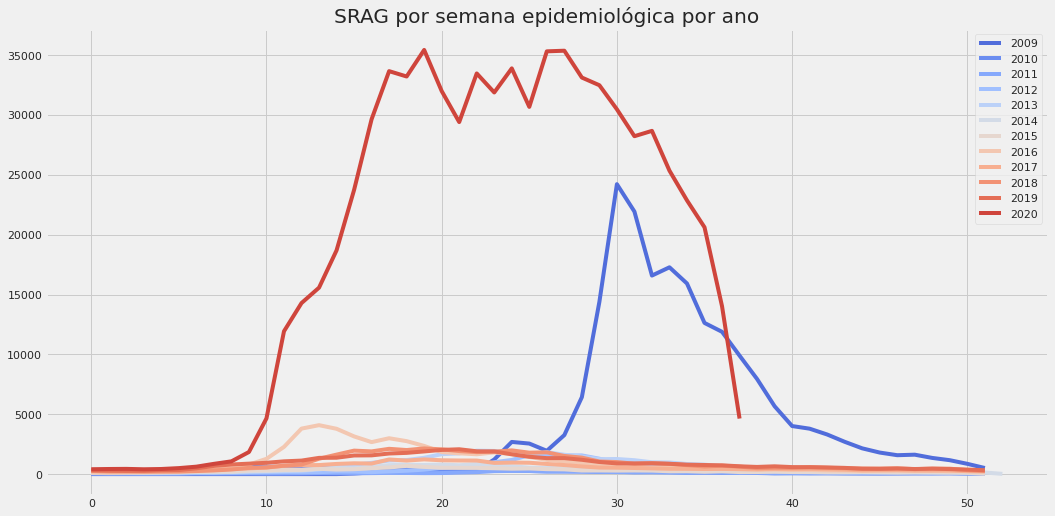

In [13]:
palette = sns.color_palette("coolwarm", len(df_srag.columns))
ax = sns.lineplot(data=df_srag, palette=palette, dashes=False)
ax.set_title('SRAG por semana epidemiológica por ano')

Uma visão alternativa para esses mesmos dados, que enfatiza a proporção em cada ano.

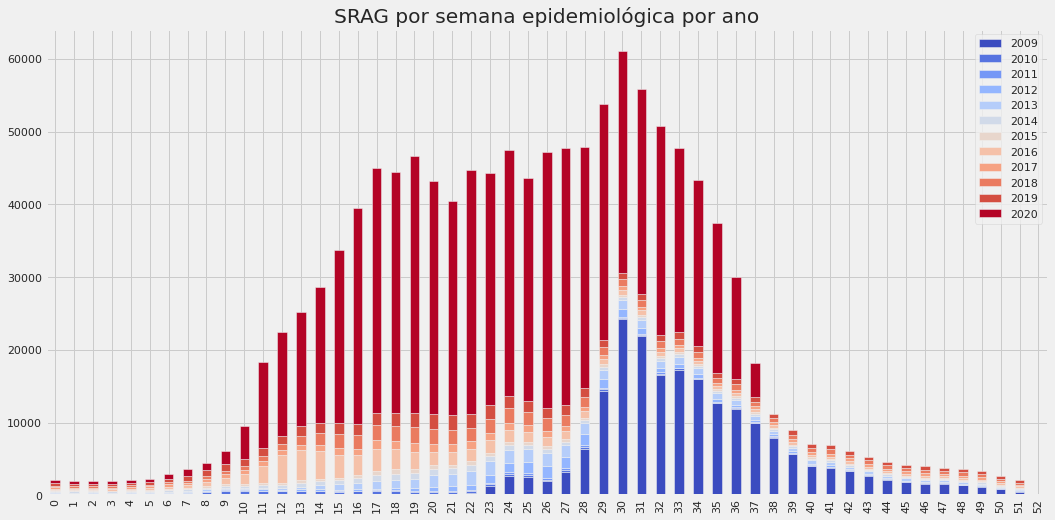

In [14]:
df_srag.plot(kind='bar', stacked=True, colormap='coolwarm', title='SRAG por semana epidemiológica por ano')

Vemos que em 2009 houve um pico bastante anormal, certamente por conta da epidemia de H1N1.

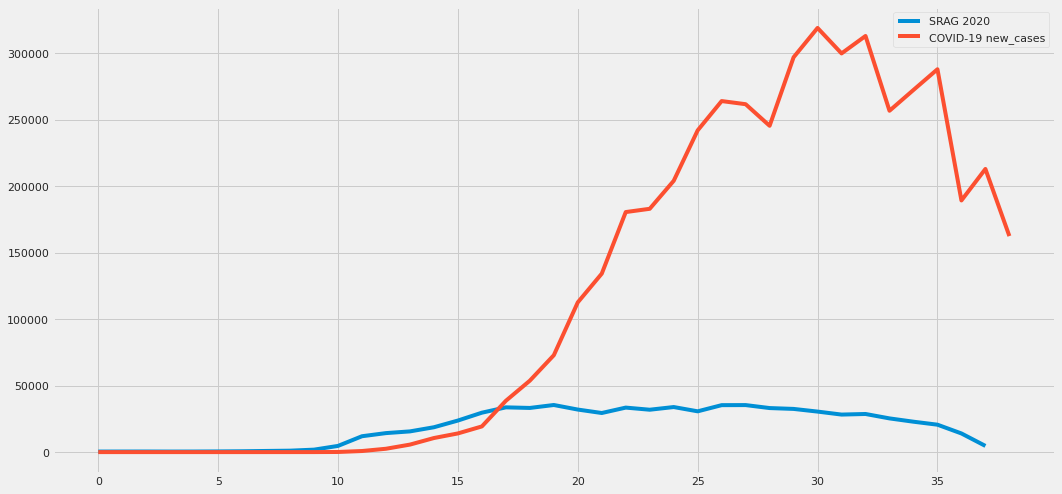

In [15]:
df_comparison =pd.concat([df_srag[2020].rename('SRAG 2020'), 
                          df_covid_target['new_cases'].rename('COVID-19 new_cases').reset_index(drop=True)], axis=1)

ax = sns.lineplot(data=df_comparison, dashes=False)

Qual a magnitude da diferença ao longo do tempo?

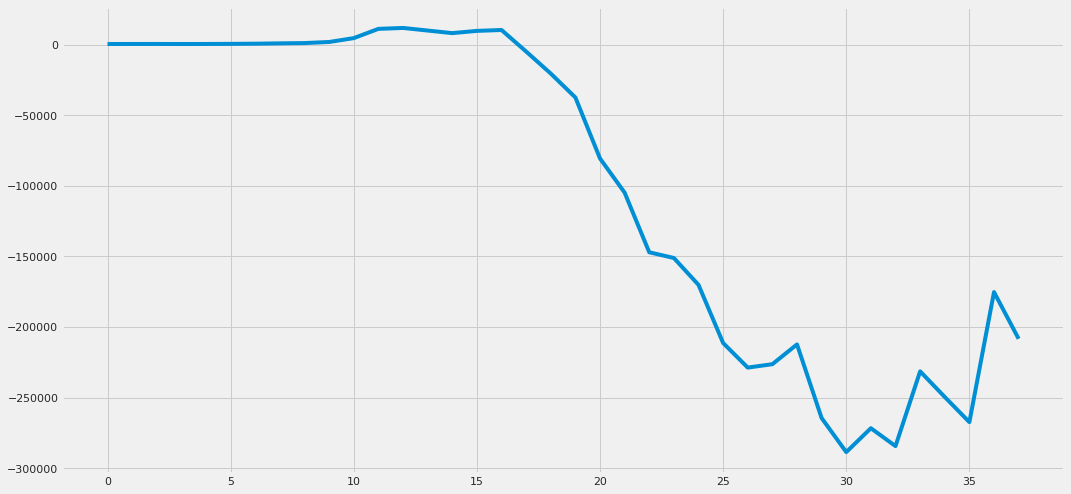

In [16]:
ax = sns.lineplot(data=(df_comparison.iloc[:, 0] - df_comparison.iloc[:, 1]), dashes=False)

## Estimativa de Efeito Causal: CausalImpact

Para estimar o efeito causal supostamente introduzido pela COVID-19, usaremos [a biblioteca CausalImpact](https://github.com/dafiti/causalimpact), a qual exige que os dados sejam dispostos de forma linear no tempo.

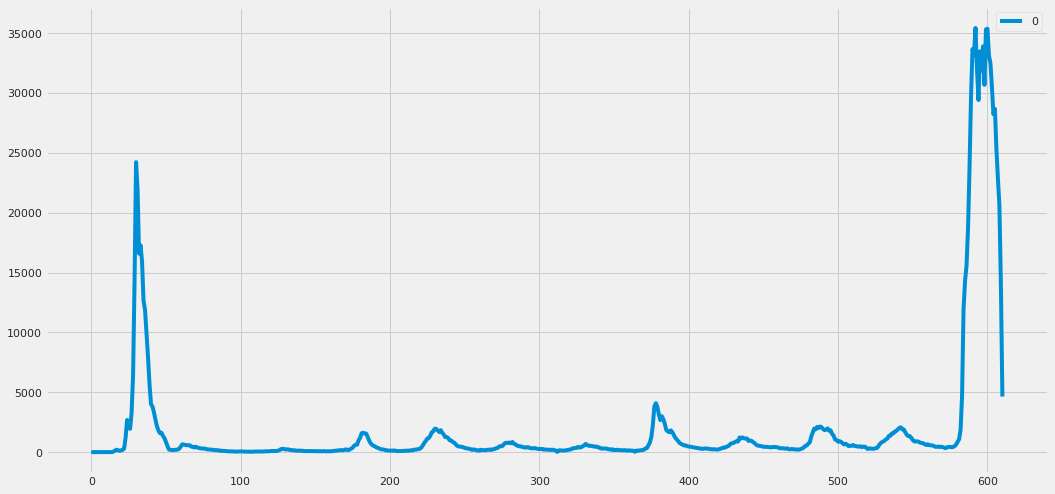

In [17]:
ax = sns.lineplot(data=df_srag_timeline, dashes=False)

Coloquemos a suposta intervenção causal na primeira semana de 2020.

In [18]:
years

array([2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019,
       2020])

Intervention week: 572
Posterior Inference {Causal Impact}
                          Average            Cumulative
Actual                    2912.23            37859.0
Prediction (s.d.)         822.72 (610.05)    10695.38 (7930.62)
95% CI                    [-377.77, 2013.58] [-4910.95, 26176.52]

Absolute effect (s.d.)    2089.51 (610.05)   27163.62 (7930.62)
95% CI                    [898.65, 3290.0]   [11682.48, 42769.95]

Relative effect (s.d.)    253.98% (74.15%)   253.98% (74.15%)
95% CI                    [109.23%, 399.89%] [109.23%, 399.89%]

Posterior tail-area probability p: 0.0
Posterior prob. of a causal effect: 100.0%

For more details run the command: print(impact.summary('report'))


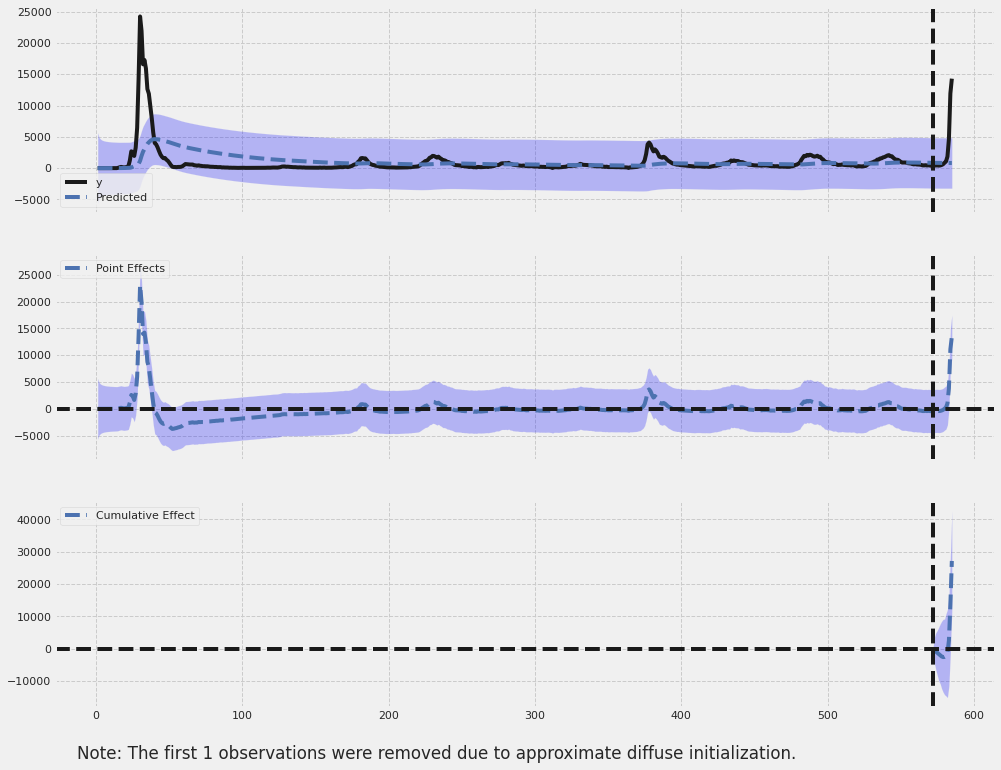

In [19]:
intervention_week = (len(years) - 1) * 52  # all years, except the last one
print("Intervention week:", intervention_week)
pre_period = [0, intervention_week]
post_period = [intervention_week+1, 585]

ci = CausalImpact(df_srag_timeline, pre_period, post_period)
print(ci.summary())
#print(ci.summary(output='report'))
ci.plot()

Podemos então isolar o efeito estimado.

In [20]:
df_causal_effect_1 = ci.inferences.dropna()[['point_effects', 'point_effects_lower', 'point_effects_upper']]
df_causal_effect_1#.head()

,point_effects,point_effects_lower,point_effects_upper
573,-416.721578,-4447.662575,3614.219420
574,-396.721578,-4427.980801,3634.537646
575,-386.721578,-4418.299002,3644.855847
576,-419.721578,-4451.617178,3612.174023
577,-396.721578,-4428.935328,3635.492173
578,-322.721578,-4355.253454,3709.810299
579,-201.721578,-4234.571555,3831.128400
580,33.278422,-3999.889630,4066.446475
581,242.278422,-3791.207680,4275.764525
582,1022.278422,-3011.525706,5056.082551


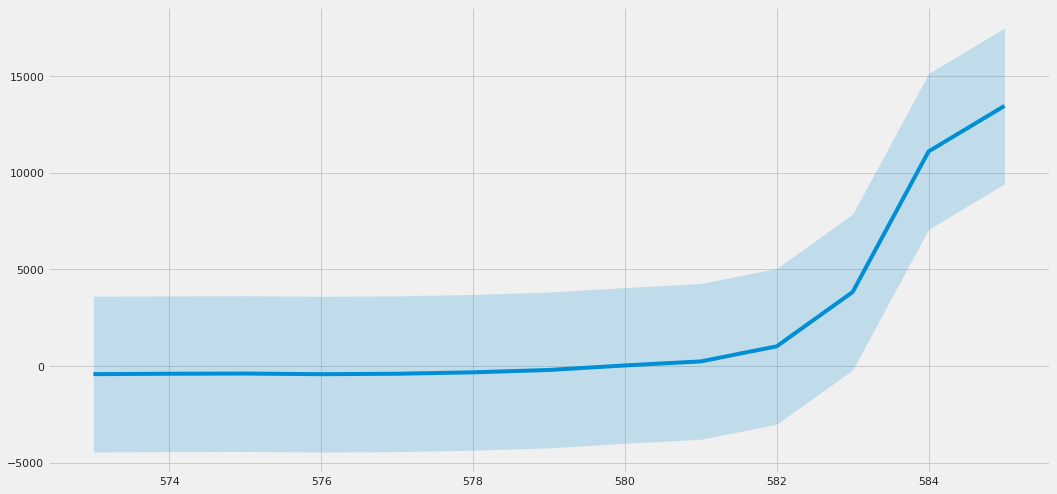

In [21]:
df_causal_effect_1['point_effects'].plot()
plt.fill_between(df_causal_effect_1.index, 
                 df_causal_effect_1[['point_effects_lower', 'point_effects_upper']].values[:, 0],
                df_causal_effect_1[['point_effects_lower', 'point_effects_upper']].values[:, 1],
                alpha=0.2)

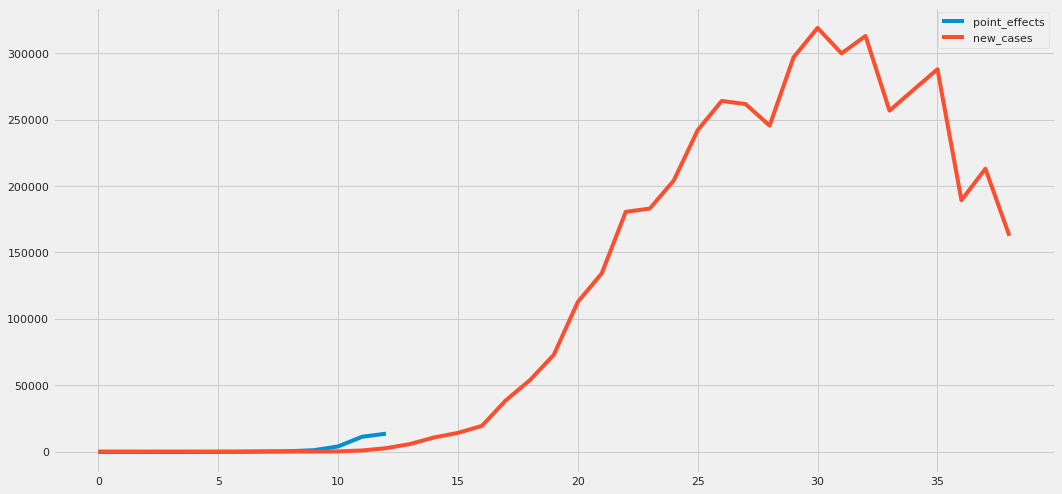

In [22]:
df_comparison_2 =pd.concat([df_causal_effect_1['point_effects'].reset_index(drop=True), 
                            df_covid_target['new_cases'].reset_index(drop=True)], axis=1)

ax = sns.lineplot(data=df_comparison_2, dashes=False)

E calcular a razão entre SRAGs e COVID-19 oficial.

8     242.278422
9      85.189869
10     45.085628
11     13.783224
12      5.358248
dtype: float64

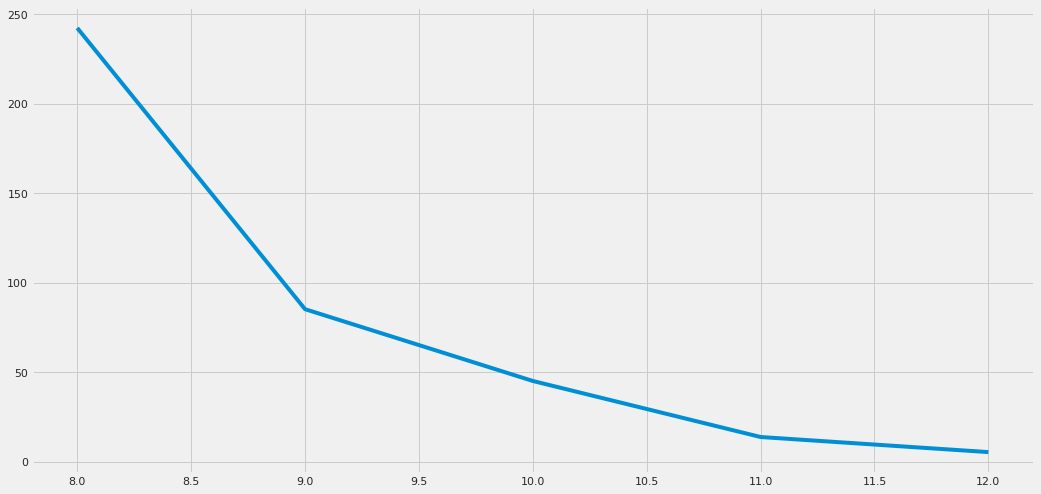

In [23]:
s_a = df_causal_effect_1['point_effects'].reset_index(drop=True)
s_b =  df_covid_target['new_cases'].reset_index(drop=True)
s_ratio_1 = (s_a/s_b)
s_ratio_1 = s_ratio_1[(s_ratio_1 != np.inf) & (s_ratio_1 != -np.inf)].dropna()
ax = sns.lineplot(data=s_ratio_1, 
                  dashes=False)
s_ratio_1

## Estimativa de Efeito Causal: Manual

Façamos agora uma análise manual, supondo-se que as mesmas semanas epidemiológicas em anos diferentes tendem a ter comportamentos semelhantes, salvo em casos excepcionais. Assim, iremos atribuir a diferença (média, mínima, máxima) observada nas semanas do ano corrente a algum fator novo, nomeadamente à COVID-19.

In [24]:
s_srag_cur = df_srag.iloc[:, -1]
df_srag_past = df_srag.iloc[:, :-1]

In [25]:
s_effect_lower = (s_srag_cur - df_srag_past.max(axis=1)).rename('causal_effect_lower')
s_effect_upper = (s_srag_cur - df_srag_past.min(axis=1)).rename('causal_effect_upper')
s_effect_mean = (s_srag_cur - df_srag_past.mean(axis=1)).rename('causal_effect_mean')


df_causal_effect_2 = pd.concat([s_effect_mean, s_effect_lower, s_effect_upper], axis=1) 
df_causal_effect_2.head(15)

,causal_effect_mean,causal_effect_lower,causal_effect_upper
0,254.727273,89.0,406.0
1,282.727273,137.0,426.0
2,294.727273,162.0,436.0
3,264.454545,126.0,403.0
4,272.090909,100.0,426.0
5,336.363636,163.0,500.0
6,411.454545,136.0,621.0
7,610.363636,174.0,856.0
8,755.000000,263.0,1065.0
9,1458.454545,973.0,1845.0


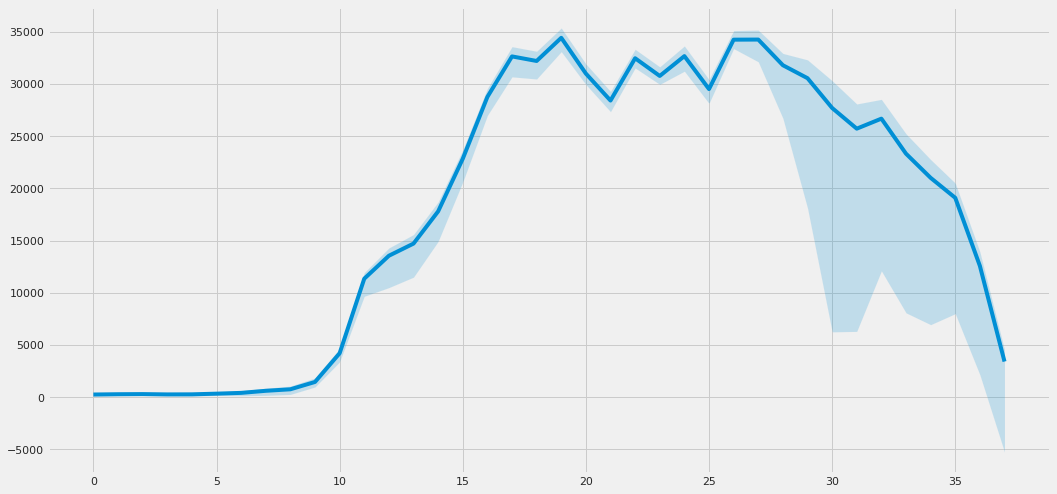

In [26]:
df_causal_effect_2['causal_effect_mean'].plot()
plt.fill_between(df_causal_effect_2.index, 
                 df_causal_effect_2[['causal_effect_lower', 'causal_effect_upper']].values[:, 0],
                 df_causal_effect_2[['causal_effect_lower', 'causal_effect_upper']].values[:, 1],
                 alpha=0.2)

8     755.000000
9     121.537879
10     49.481283
11     14.075231
12      5.388453
13      2.607812
14      1.681165
15      1.625398
16      1.488522
17      0.845400
18      0.599028
19      0.472013
20      0.274991
21      0.211510
22      0.179692
23      0.168023
24      0.160000
25      0.121868
26      0.129609
27      0.130817
28      0.129464
29      0.102824
30      0.086770
31      0.085712
32      0.085180
33      0.090779
34      0.077079
35      0.066270
36      0.066377
37      0.016014
dtype: float64

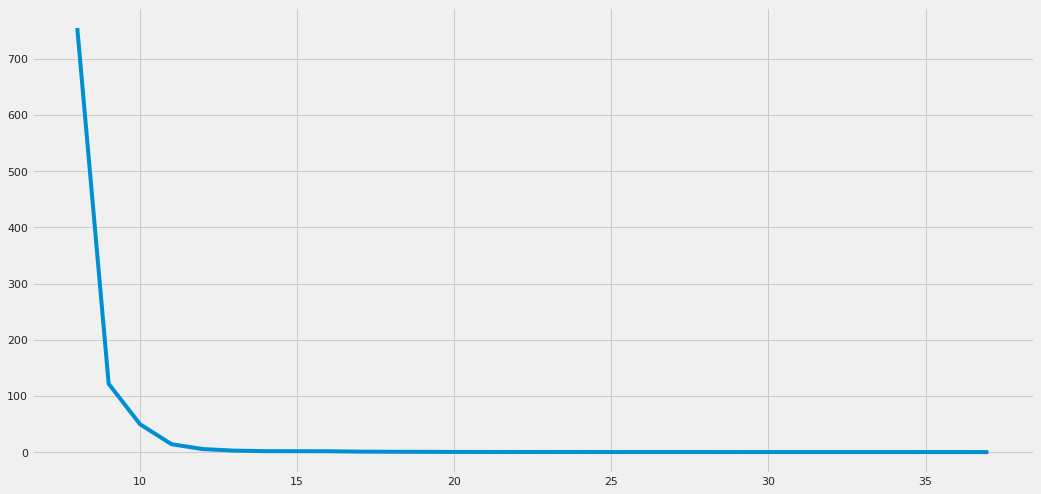

In [27]:
s_a = df_causal_effect_2['causal_effect_mean'].reset_index(drop=True)
s_b =  df_covid_target['new_cases'].reset_index(drop=True)

s_ratio_2 = (s_a/s_b)

s_ratio_2 = s_ratio_2[(s_ratio_2 != np.inf) & (s_ratio_2 != -np.inf)].dropna()
ax = sns.lineplot(data=s_ratio_2, 
                  dashes=False)
s_ratio_2

Os resultados dessa última estimativa de efeito causal parecem mais confiáveis, então a tomaremos como base para a conclusão deste estudo.

In [28]:
s_ratio = s_ratio_2

## Conclusão

Nota-se grande discrepância entre casos usuais de SRAG e casos reportados. Atribuimos assim os casos adicionais à COVID-19. Alguns outros ajustes são necessários para obtermos multiplicadores de ajuste adequados:

  - Note-se ainda que os casos de SRAG reportados referem-se a hospitalizações, que são apenas uma parte dos casos totais esperados de COVID-19. Portanto, para se estimar os casos totais de COVID-19, devemos ainda ajustar a estimativa de hospitalizados de acordo com a probabilidade de ser hospitalizado dado que se tem COVID-19. 
  - Usamos apenas dados considerados já confiáveis. Isso tipicamente exige que desconsideremos algumas semanas mais recentes (variável `min_trustworthy_week`), cujos valores ainda estão sujeitos a grandes mudanças à lentidão com a qual a base de SRAG é atualizada.
  - Supomos que o multiplicador de ajuste nunca pode ser menor do que 1.0, posto que queremos contemplar ao menos os casos reportados.

In [29]:
# Combination of hospitalization rates per age found in 
#
#    https://www.thelancet.com/journals/laninf/article/PIIS1473-3099(20)30243-7/fulltext
# with demographic data found in
# 
#    https://censo2010.ibge.gov.br/sinopse/index.php?dados=12
#
p_hospitalization = (0.037+0.04)*0.0 + (0.046+0.045)*0.000408 + (0.045+0.044)*0.0105 + (0.04+0.35)*0.0343 + (0.033+0.030)*0.0425 +\
                    (0.025+0.02)*0.0816 + (0.016+0.012)*0.118 + (0.009+0.006)*0.166 + (0.004+0.002+0.001)*0.184   
                     #0.034 #0.2
p_hospitalization

0.027780127999999998

8     27177.700549
9      4374.993477
10     1781.175502
11      506.665456
12      193.967889
13       93.873307
14       60.516830
15       58.509381
16       53.582245
17       30.431822
18       21.563194
19       16.991019
20        9.898823
21        7.613719
22        6.468361
23        6.048334
24        5.759508
25        4.386872
26        4.665541
27        4.709012
28        4.660324
29        3.701351
30        3.123471
31        3.123471
32        3.123471
33        3.123471
34        3.123471
35        3.123471
36        3.123471
37        3.123471
Name: SRAG_adjustment_multiplier, dtype: float64

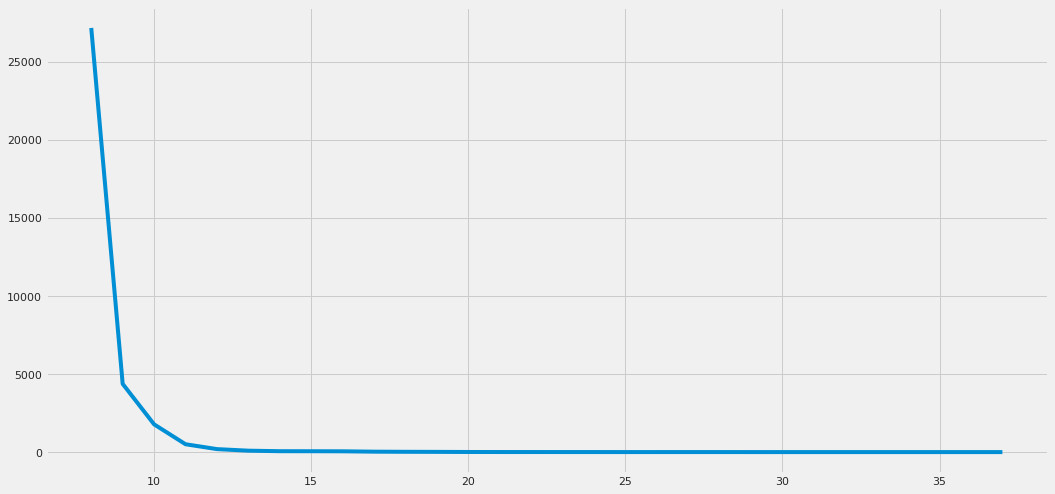

In [30]:
s_adjustment_multipler = s_ratio[s_ratio > 0] / p_hospitalization
s_adjustment_multipler = s_adjustment_multipler.rename('SRAG_adjustment_multiplier')

# we use only the estimates that are trustworthy
s_adjustment_multipler.loc[min_trustworthy_week+1:] = s_adjustment_multipler.loc[min_trustworthy_week]


# we assume that data can never be less than the original estimate
s_adjustment_multipler[s_adjustment_multipler < 1.0] = 1.0

ax = sns.lineplot(data=s_adjustment_multipler, 
                  dashes=False)


s_adjustment_multipler

Vemos assim que as diferenças estimadas são bastante expressivas, o que deve ter impacto na previsão da dinâmica epidemiológica.

Salvemos esses multiplicadores de ajuste para uso posterior. Por conveniência, vamos diarizar esses valores.

In [31]:
weeks = range(0, s_adjustment_multipler.index[-1])

In [32]:
df_daily_adjustment_multipler = \
    df_covid_target\
        .reset_index()\
        .merge(s_adjustment_multipler, left_index=True, right_index=True)\
        .set_index('date')\
        .resample('D')\
        .bfill()\
        [['SRAG_adjustment_multiplier']]

df_daily_adjustment_multipler

,SRAG_adjustment_multiplier
date,
2020-02-29,27177.700549
2020-03-01,4374.993477
2020-03-02,4374.993477
2020-03-03,4374.993477
2020-03-04,4374.993477
...,...
2020-09-15,3.123471
2020-09-16,3.123471
2020-09-17,3.123471


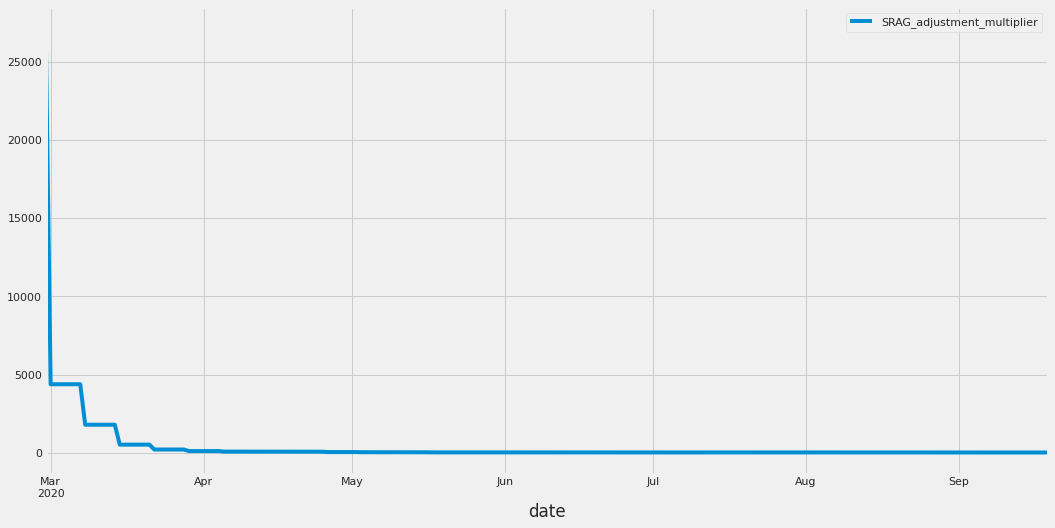

In [33]:
df_daily_adjustment_multipler.plot()

In [34]:
df_daily_adjustment_multipler.to_csv('../results/srag_adjustment_multipliers.brazil.csv')